In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import tensorflow as tf
import pandas as pd
from time import time
import cv2
import PIL
import os
%matplotlib inline

<h1><center>Signal traffic prediction</center></h1>

### Autor
- Nombre: Edwin Jahir Rueda Rojas
- email: ejrueda95g@gmail.com

- La finalidad de este notebook es construir un modelo de AI para identificar señales de tráfico (58 señales diferentes).

- El dataset empleado es el [Chinese traffic sign dataset](http://www.nlpr.ia.ac.cn/pal/trafficdata/recognition.html)

### Dataset
- El dataset cuenta con 4170 imágenes para el entrenamiento y 1994 para el test.
- Las imágenes están etiquetadas con 58 categorías diferentes.
- Las imágenes tiene tamaño variado.

### Cargamos los datos

In [4]:
batch_size = 32
img_height = 100
img_width = 100

root = "../data/traffic_signal/"

x_train_files = os.listdir(root + "tsrd-train/")
y_train_files = pd.read_csv(root + "TSRD-Train Annotation/TsignRecgTrain4170Annotation.txt",
                            delimiter=";", names=["width","height","x1","y1","x2","y2", "label", "vacio"],
                            index_col=0)

x_test_files = os.listdir(root + "TSRD-Test/")
y_test_files = pd.read_csv(root + "TSRD-Test Annotation/TsignRecgTest1994Annotation.txt",
                          delimiter=";", names=["width","height","x1","y1","x2","y2", "label", "vacio"],
                            index_col=0)

print("# de imágenes para entrenar:", len(x_train_files))
print("# de imágenes para probar:", len(x_test_files))

# de imágenes para entrenar: 4170
# de imágenes para probar: 1994


In [5]:
x_train_files[:3]

['030_1_0035.png', '054_1_0013.png', '001_1_0010.png']

In [6]:
y_train_files.head()

,width,height,x1,y1,x2,y2,label,vacio
000_0001.png,134,128,19,7,120,117,0,NaN
000_0002.png,165,151,23,12,149,138,0,NaN
000_0003.png,128,122,22,14,116,105,0,NaN
000_0010.png,80,73,14,8,67,63,0,NaN
000_0011.png,186,174,36,15,155,157,0,NaN


In [7]:
name_img = np.random.choice(y_train_files.index)
print("imagen:", name_img)
img = np.array(PIL.Image.open("../data/traffic_signal/tsrd-train/"+name_img))
print("iamgen original:", img.shape)
x1 = int(y_train_files.loc[name_img].x1)
y1 = int(y_train_files.loc[name_img].y1)
x2 = int(y_train_files.loc[name_img].x2)
y2 = int(y_train_files.loc[name_img].y2)
img_recortada = img[y1:y2, x1:x2]
print("imagen recortada:", img_recortada.shape)

imagen: 055_1_0011.png
iamgen original: (164, 181, 3)
imagen recortada: (119, 121, 3)


categoria: 55.0


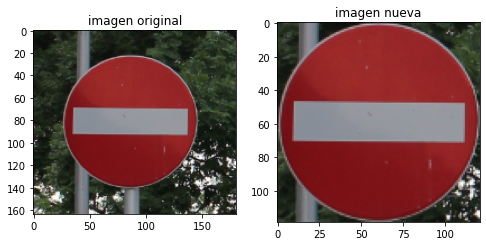

In [8]:
print("categoria:", y_train_files.loc[name_img].label)
plt.figure(figsize=(8,5))
plt.subplot(1,2,1)
plt.imshow(img)
plt.title("imagen original")

plt.subplot(1,2,2)
plt.imshow(img_recortada)
plt.title("imagen nueva");

- Después de recortar las imágenes hay que escalarlas a una dimensión fija, para ello usamos <b>opencv</b>, librería para el procesamiento de imágenes.

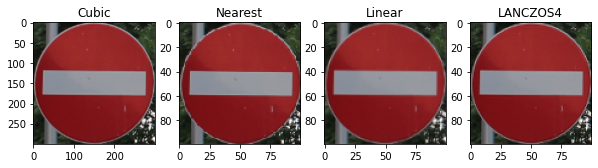

In [9]:
plt.figure(figsize=(10, 5))
plt.subplot(1,4,1)
plt.title("Cubic")
plt.imshow(cv2.resize(img_recortada, dsize=(300,300), interpolation=cv2.INTER_CUBIC))

plt.subplot(1,4,2)
plt.title("Nearest")
plt.imshow(cv2.resize(img_recortada, dsize=(100,100), interpolation=cv2.INTER_NEAREST));

plt.subplot(1,4,3)
plt.title("Linear")
plt.imshow(cv2.resize(img_recortada, dsize=(100,100), interpolation=cv2.INTER_LINEAR));

plt.subplot(1,4,4)
plt.title("LANCZOS4")
plt.imshow(cv2.resize(img_recortada, dsize=(100,100), interpolation=cv2.INTER_LANCZOS4));

- se crea una lista con las categorias de las señales, a su vez, las imágenes son recortadas y guardadas en una matriz

In [10]:
#para los datos de entrenamiento
tic = time()
y_train_label = []
X_train_matrix = np.zeros((y_train_files.shape[0], img_height, img_width, 3))
count = 0
for f in x_train_files:
    #añadimos la categoria
    y_train_label.append(int(y_train_files.loc[f].label))
    #abrimos la imagen
    img = np.array(PIL.Image.open(root + "tsrd-train/"+f))
    x1 = int(y_train_files.loc[f].x1)
    y1 = int(y_train_files.loc[f].y1)
    x2 = int(y_train_files.loc[f].x2)
    y2 = int(y_train_files.loc[f].y2)
    img_recortada = img[y1:y2, x1:x2]
    img_resize = cv2.resize(img_recortada, dsize=(100,100), interpolation=cv2.INTER_CUBIC)
    X_train_matrix[count] = img_resize
    count += 1

X_train_matrix /= 255
toc = time()
print("tiempo de cómputo:", toc-tic, "[s]")

tiempo de cómputo: 11.223546504974365 [s]


In [11]:
#para los datos de test
tic = time()
y_test_label = []
X_test_matrix = np.zeros((y_test_files.shape[0], img_height, img_width, 3))
count = 0
for f in x_test_files:
    #añadimos la categoria
    y_test_label.append(int(y_test_files.loc[f].label))
    #abrimos la imagen
    img = np.array(PIL.Image.open(root + "TSRD-Test/"+f))
    x1 = int(y_test_files.loc[f].x1)
    y1 = int(y_test_files.loc[f].y1)
    x2 = int(y_test_files.loc[f].x2)
    y2 = int(y_test_files.loc[f].y2)
    img_recortada = img[y1:y2, x1:x2]
    img_resize = cv2.resize(img_recortada, dsize=(img_height,img_width), interpolation=cv2.INTER_CUBIC)
    X_test_matrix[count] = img_resize
    count += 1

X_test_matrix /= 255
toc = time()
print("tiempo de cómputo:", toc-tic, "[s]")

tiempo de cómputo: 4.470564603805542 [s]


In [12]:
y_train_label = np.array(y_train_label)
y_test_label = np.array(y_test_label)

print("Datos de entrenamiento:")
print(X_train_matrix.shape, y_train_label.shape)
print("Datos de prueba:")
print(X_test_matrix.shape, y_test_label.shape)

Datos de entrenamiento:
(4170, 100, 100, 3) (4170,)
Datos de prueba:
(1994, 100, 100, 3) (1994,)


In [13]:
hist_train = []
for val in np.unique(y_train_label):
    hist_train.append(sum(y_train_label == val))
    
hist_test = []
for val in np.unique(y_test_label):
    hist_test.append(sum(y_train_label == val))

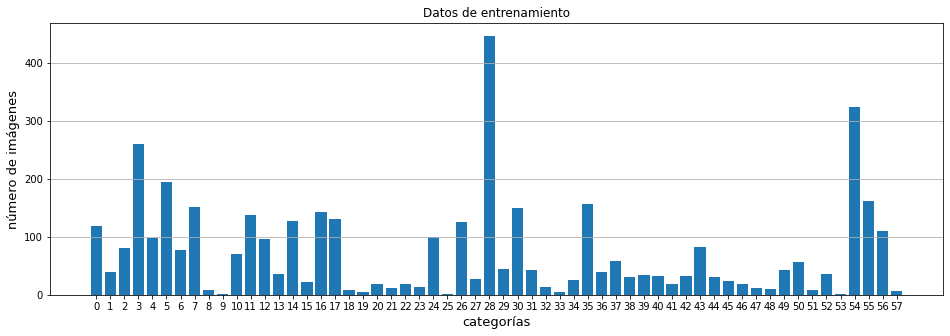

In [14]:
plt.figure(figsize=(16,5))
plt.title("Datos de entrenamiento")
plt.bar(np.unique(y_train_label), hist_train)
plt.grid(axis="y")
plt.ylabel("número de imágenes", fontsize=13)
plt.xlabel("categorías", fontsize=13)
plt.xticks(np.unique(y_train_label), np.unique(y_train_label));

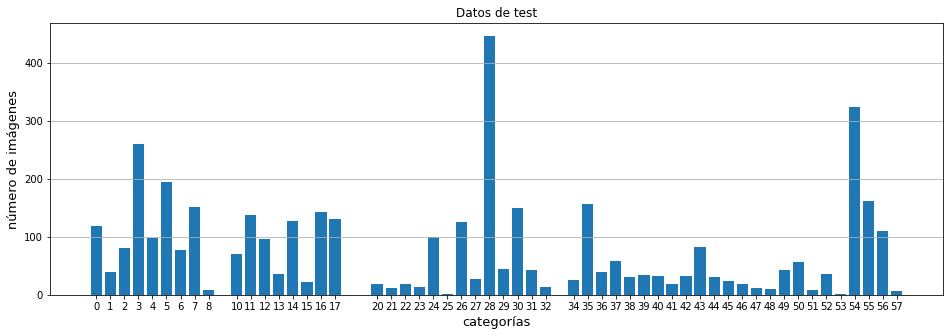

In [15]:
plt.figure(figsize=(16,5))
plt.title("Datos de test")
plt.bar(np.unique(y_test_label), hist_test)
plt.grid(axis="y")
plt.ylabel("número de imágenes", fontsize=13)
plt.xlabel("categorías", fontsize=13)
plt.xticks(np.unique(y_test_label), np.unique(y_test_label));

In [16]:
np.where(y_train_label==9)

(array([ 158, 3581]),)

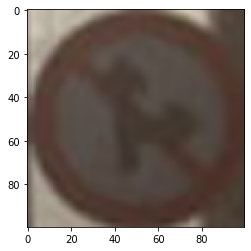

In [17]:
plt.imshow(X_train_matrix[158]);

### Observaciones
- hay categorías con pocas imágenes de entrenamiento, y algunas categorías no tienen imágenes para probar. Recomendaría para fines de aprendizaje (educativos) eliminarlas.

- Por ahora entrenaremos con todas las imágenes.

### Ajustando los datos
- Ahora se necesita ajustar el formato que contiene las variables <b>label</b> debido a que para problemas de clasificación de múltiples categorias tensorflow admite solo una matrix de ceros y unos que codifica todas las categorías.

- Para ello utilizamos el <b>OneHotEncoder</b>, el cual deberemos guardar como un .pk para poder decodificar la predicción de la red en nuevas imágenes.

In [18]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder()
y_train_encoder = ohe.fit_transform(np.array(y_train_label).reshape(-1,1)).toarray()
y_test_encoder = ohe.transform(np.array(y_test_label).reshape(-1,1)).toarray()

### Red neuronal

- Debido a que la imágenes no son "dificiles de distinguir", comenzaremos con una red neuronal sencilla.

In [19]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=3, padding="same",
                                 input_shape = (img_width, img_height, 3), activation="relu"))
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=5, strides=2, activation="relu"))
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=2, strides=1, activation="relu"))
model.add(tf.keras.layers.MaxPool2D((2,2)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(150))
model.add(tf.keras.layers.Dropout(.2))
model.add(tf.keras.layers.Dense(58, activation="softmax"))

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 32)        12832     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 47, 47, 64)        8256      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 23, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 33856)             0         
_________________________________________________________________
dense (Dense)                (None, 150)               5078550   
_________________________________________________________________
dropout (Dropout)            (None, 150)               0

In [20]:
hist_model = model.fit(X_train_matrix, y_train_encoder, validation_data=(X_test_matrix, y_test_encoder),
                       epochs=5)

Epoch 1/5
131/131 [==============================] - 32s 242ms/step - loss: 2.3708 - accuracy: 0.4998 - val_loss: 0.5011 - val_accuracy: 0.8726
Epoch 2/5
131/131 [==============================] - 32s 241ms/step - loss: 0.0946 - accuracy: 0.9750 - val_loss: 0.5079 - val_accuracy: 0.8967
Epoch 3/5
131/131 [==============================] - 32s 244ms/step - loss: 0.0188 - accuracy: 0.9956 - val_loss: 0.4021 - val_accuracy: 0.9198
Epoch 4/5
131/131 [==============================] - 32s 241ms/step - loss: 0.0126 - accuracy: 0.9979 - val_loss: 0.4605 - val_accuracy: 0.9198
Epoch 5/5
131/131 [==============================] - 32s 243ms/step - loss: 0.0348 - accuracy: 0.9905 - val_loss: 0.5846 - val_accuracy: 0.9047


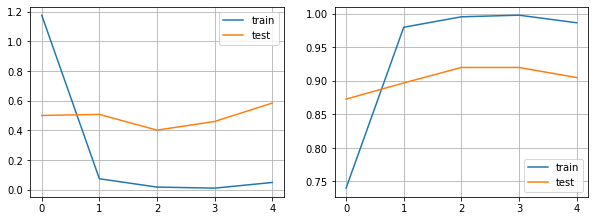

In [21]:
plt.figure(figsize=(10,3.5))
plt.subplot(1,2,1)
plt.plot(hist_model.history["loss"], label="train")
plt.plot(hist_model.history["val_loss"], label="test");
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.plot(hist_model.history["accuracy"], label="train")
plt.plot(hist_model.history["val_accuracy"], label="test");
plt.legend()
plt.grid()
#hist_model.history

In [22]:
from sklearn.metrics import confusion_matrix

y_predict = model.predict(X_test_matrix)
y_predict_decoder = ohe.inverse_transform(y_predict)[:,0]

cm_test = confusion_matrix(y_predict_decoder, y_test_label)

In [23]:
model.save("../data/traffic_signal/models/")

INFO:tensorflow:Assets written to: ../data/traffic_signal/models/assets


In [24]:
import pickle as pk

pk.dump(ohe, open("../data/traffic_signal/one_hot_enconder_model1.pk","wb"))

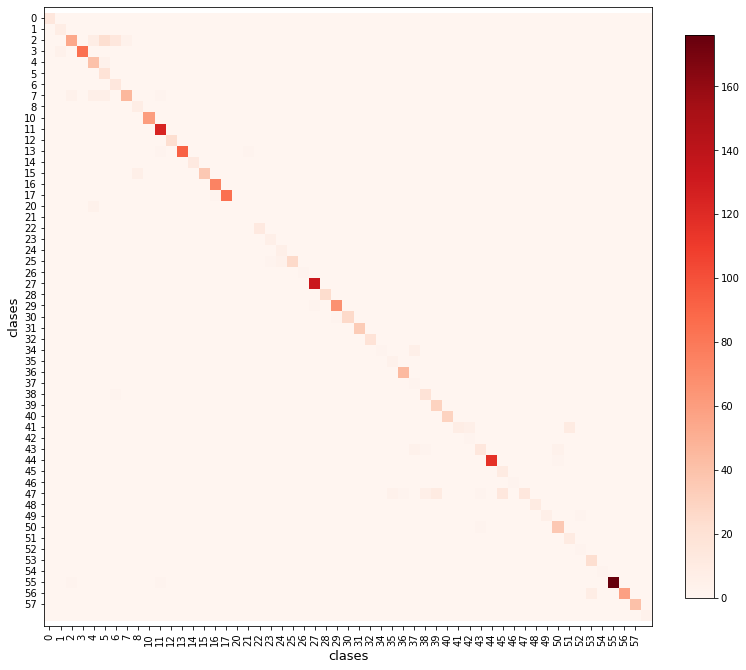

In [26]:
fig, ax = plt.subplots(figsize=(12,12))
im = ax.imshow(cm_test, cmap=plt.cm.Reds)
ax.set_xticks(range(len(np.unique(y_test_label))))
ax.set_yticks(range(len(np.unique(y_test_label))))
#para colocarle los valores a los ejes
ax.set_xticklabels(np.unique(y_test_label), rotation=90);
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
ax.set_yticklabels(np.unique(y_test_label));
ax.set_xlabel("clases", fontsize=13)
ax.set_ylabel("clases", fontsize=13)
cbar = ax.figure.colorbar(im, fraction=0.042);
#cbar.ax.set_xlabel("");

In [27]:
def get_top_n_score(target, prediction, n):
    #ordeno los indices de menor a mayor probabilidad
    pre_sort_index = np.argsort(prediction)
    #ordeno de mayor probabilidad a menor
    pre_sort_index = pre_sort_index[:,::-1]
    #cojo las n-top predicciones
    pre_top_n = pre_sort_index[:,:n]
    #obtengo el conteo de acierto
    precision = [1 if target[i] in pre_top_n[i] else 0 for i in range(target.shape[0])]
    #se retorna la precision
    return np.mean(precision)

In [28]:
get_top_n_score(y_test_label, y_predict, 1)

0.9047141424272819

In [62]:
from tensorflow.keras.metrics import TopKCategoricalAccuracy

In [77]:
tp_k = TopKCategoricalAccuracy(k=5)

In [78]:
tp_k.update_state(y_test_encoder, y_predict)

<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=1994.0>

In [79]:
tp_k.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.98595786>

In [81]:
get_top_n_score(y_test_label, y_predict, 5)

0.9859578736208626